<a href="https://colab.research.google.com/github/qahtanaa/OnSubGroupFairness/blob/main/4thegraph_decisionboundary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
%reset -f

In [25]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
from matplotlib import pyplot as plt
from numpy import where
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

Before Running SMOTE:  Counter({0: 500, 1: 500})


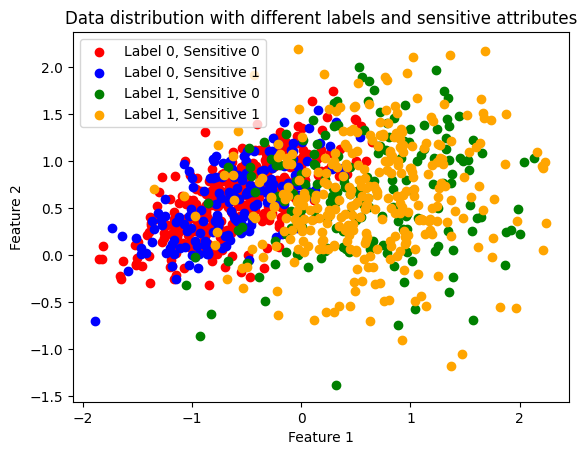

In [26]:
# Create the dataset
import random
random.seed(3)
n=1000
X_org, y_org = make_classification(n_samples=n, n_features=2, n_redundant=0,
    n_clusters_per_class=1, weights=[0.5, 0.5], flip_y=0, class_sep = 0.6, random_state=3
                                   )

minority_proportion = 0.3
sensitive_attr = np.random.choice([0, 1], size=n, p=[1 - minority_proportion, minority_proportion])

y_org = 1 - y_org
# Set the proportions for sensitive attribute based on the label
sensitive_attribute = np.zeros_like(y_org)
sensitive_attribute[y_org == 1] = np.random.choice([0, 1], size=(y_org == 1).sum(), p=[1/3, 2/3])
sensitive_attribute[y_org == 0] = np.random.choice([0, 1], size=(y_org == 0).sum(), p=[2/3, 1/3])

data = pd.DataFrame(X_org, columns=['feature1', 'feature2'])
data['sensitive_attribute'] = sensitive_attribute
data['label'] = y_org

# Summarize class distribution
counter = Counter(y_org)
print("Before Running SMOTE: ", counter)

# Plot the data with 4 different colors for each combination of label and sensitive attribute
colors = { (0, 0): 'red', (0, 1): 'blue', (1, 0): 'green', (1, 1): 'orange' }
for (label, sensitive_attr), color in colors.items():
    row_ix = where((y_org == label) & (sensitive_attribute == sensitive_attr))[0]
    plt.scatter(X_org[row_ix, 0], X_org[row_ix, 1], label=f'Label {label}, Sensitive {sensitive_attr}', c=color)

plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data distribution with different labels and sensitive attributes')
plt.show()


In [27]:
group_counts = data.groupby(['label', 'sensitive_attribute']).size().reset_index(name='count')
print(group_counts)

   label  sensitive_attribute  count
0      0                    0    333
1      0                    1    167
2      1                    0    176
3      1                    1    324


In [28]:
# Split the data into 70% train and 30% test with stratification based on label and sensitive attribute
train_data, test_data = train_test_split(data, test_size=0.30, shuffle=True, stratify=data[['label', 'sensitive_attribute']], random_state=1)

# Display the count of instances in each group for both train and test sets
train_counts = train_data.groupby(['label', 'sensitive_attribute']).size().reset_index(name='count')
test_counts = test_data.groupby(['label', 'sensitive_attribute']).size().reset_index(name='count')

print("Train Data Counts:\n", train_counts)
print("Test Data Counts:\n", test_counts)

Train Data Counts:
    label  sensitive_attribute  count
0      0                    0    233
1      0                    1    117
2      1                    0    123
3      1                    1    227
Test Data Counts:
    label  sensitive_attribute  count
0      0                    0    100
1      0                    1     50
2      1                    0     53
3      1                    1     97


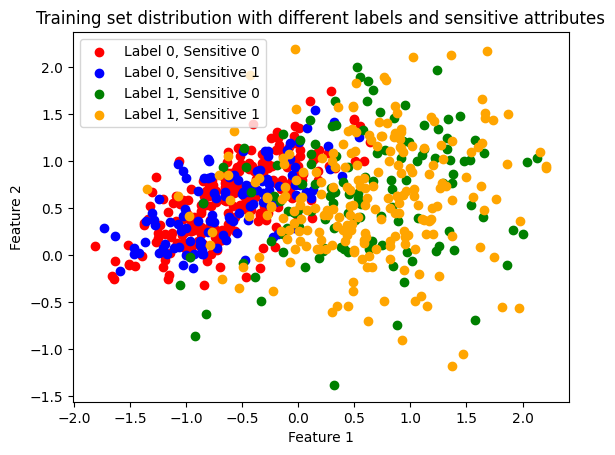

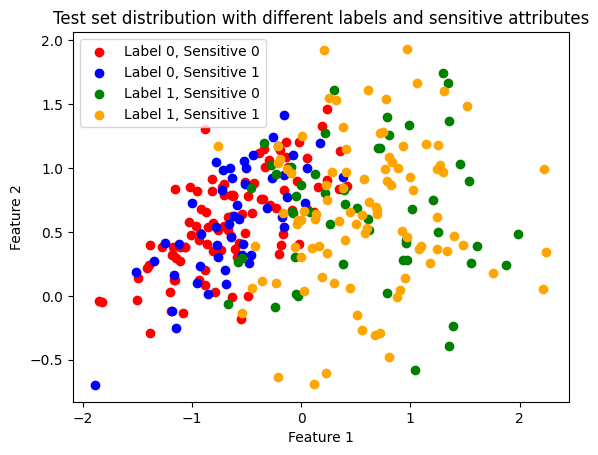

Length of training set: 700
Length of test set: 300


In [29]:
# Split the features and labels for train and test sets
X_train = train_data[['feature1', 'feature2']].values
y_train = train_data['label'].values
sensitive_attr_train = train_data['sensitive_attribute'].values

X_test = test_data[['feature1', 'feature2']].values
y_test = test_data['label'].values
sensitive_attr_test = test_data['sensitive_attribute'].values

# Plot the training set with 4 different colors for each combination of label and sensitive attribute
colors = { (0, 0): 'red', (0, 1): 'blue', (1, 0): 'green', (1, 1): 'orange' }
for (label, sensitive_attr), color in colors.items():
    row_ix = where((y_train == label) & (sensitive_attr_train == sensitive_attr))[0]
    plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=f'Label {label}, Sensitive {sensitive_attr}', c=color)

plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Training set distribution with different labels and sensitive attributes')
plt.show()

# Plot the test set with 4 different colors for each combination of label and sensitive attribute
for (label, sensitive_attr), color in colors.items():
    row_ix = where((y_test == label) & (sensitive_attr_test == sensitive_attr))[0]
    plt.scatter(X_test[row_ix, 0], X_test[row_ix, 1], label=f'Label {label}, Sensitive {sensitive_attr}', c=color)

plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Test set distribution with different labels and sensitive attributes')
plt.show()

print(f'Length of training set: {len(X_train)}')
print(f'Length of test set: {len(X_test)}')

In [30]:
# Train a logisitic regression model
# Train the model with the training subset
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Test the model on the test subset
result = logreg.predict(X_test)
# Display the confusion matrix to check the performance of your model
confusion_matrix(result, y_test)


array([[138,  27],
       [ 12, 123]])

In [31]:
sensitive_groups = [0, 1]
for sensitive_group in sensitive_groups:
    y_test_group = y_test[sensitive_attr_test == sensitive_group]
    y_pred_group = result[sensitive_attr_test == sensitive_group]

    cm_group = confusion_matrix(y_pred_group, y_test_group)
    print(f"Confusion Matrix for Sensitive Attribute = {sensitive_group}:")
    print(cm_group)

Confusion Matrix for Sensitive Attribute = 0:
[[91 13]
 [ 9 40]]
Confusion Matrix for Sensitive Attribute = 1:
[[47 14]
 [ 3 83]]


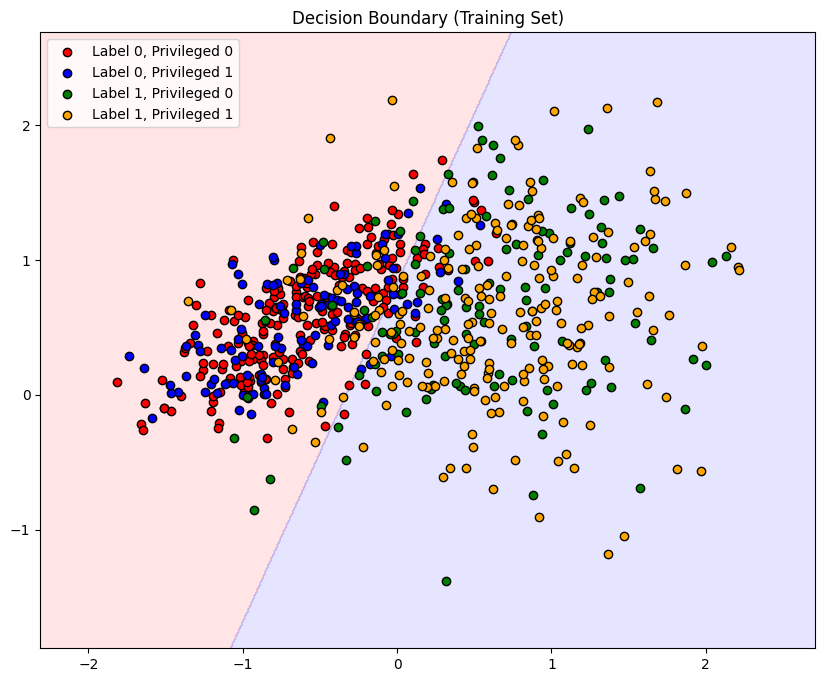

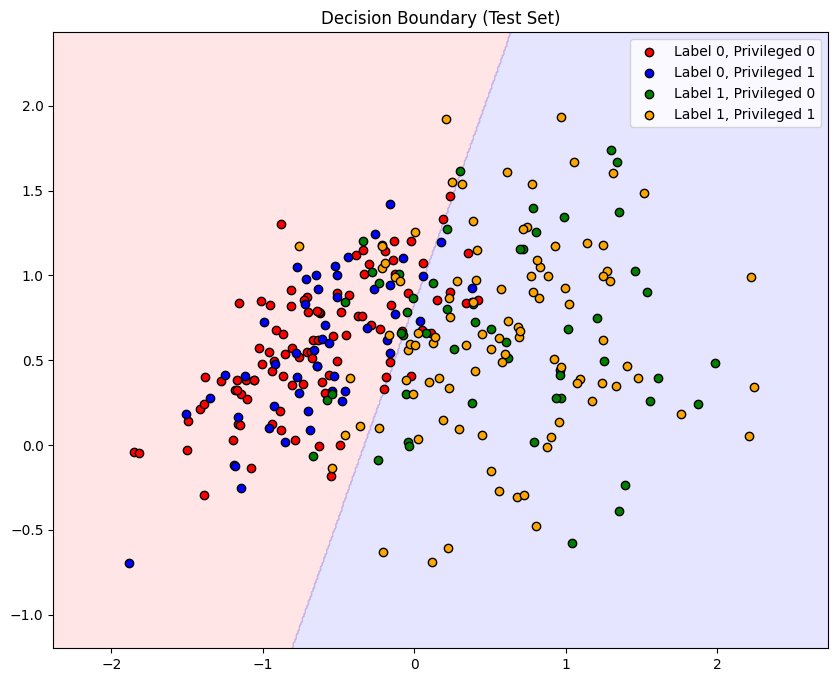

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from numpy import where
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

# Plot decision boundary
def plot_decision_boundary(X, y, sensitive_attr, model, title, figsize=(12, 8)):
    plt.figure(figsize=figsize)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))

    # Plot the data points with four different colors
    colors = { (0, 0): 'red', (0, 1): 'blue', (1, 0): 'green', (1, 1): 'orange' }
    for (label, sensitive_attr_val), color in colors.items():
        row_ix = np.where((y == label) & (sensitive_attr == sensitive_attr_val))[0]
        plt.scatter(X[row_ix, 0], X[row_ix, 1], label=f'Label {label}, Privileged {sensitive_attr_val}', c=color, edgecolors='k')

    plt.legend()
    #plt.xlabel('Feature 1')
    #plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

# Plot decision boundary for the training set
plot_decision_boundary(X_train, y_train, sensitive_attr_train, logreg, 'Decision Boundary (Training Set)', figsize=(10, 8))

# Plot decision boundary for the test set with a larger figure
plot_decision_boundary(X_test, y_test, sensitive_attr_test, logreg, 'Decision Boundary (Test Set)', figsize=(10, 8))



In [33]:
f1 = f1_score(y_test, result, average=None)
acc = accuracy_score(y_test, result, normalize=True)
bacc = balanced_accuracy_score(y_test, result)
print ("F1-Score = {}\nAccuracy = {}\nBalanced Accuracy = {}".format(f1, acc, bacc))

F1-Score = [0.87619048 0.86315789]
Accuracy = 0.87
Balanced Accuracy = 0.87


___________________________________________________________
DBSCAN


In [34]:
!pip install gower

In [35]:
import math
from gower import gower_matrix
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import random

In [36]:
def find_optimal_epsilon(filtered_data, cat_features, min_samples, distance_matrix, eps_step=0.001, eps_min=0.01, eps_max=1.1):

    def cluster_count(eps):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
        labels = dbscan.fit_predict(distance_matrix)
        unique_labels = np.unique(labels)
        n_clusters = len(unique_labels)  # - (1 if -1 in unique_labels else 0)
        return n_clusters, unique_labels

    # Binary search for optimal epsilon
    while eps_max - eps_min > eps_step:
        eps_mid = (eps_min + eps_max) / 2
        n_clusters_mid, labels_mid = cluster_count(eps_mid)
        print(eps_mid, n_clusters_mid, labels_mid, 'mids')

        if n_clusters_mid == 1:
            if -1 in labels_mid:
                eps_min = eps_mid  # Only noise points, increase epsilon
            else:
                eps_max = eps_mid  # Only core points, decrease epsilon
        elif n_clusters_mid > 2:
            eps_min = eps_mid  # More than two clusters, increase epsilon
        else:
            eps_max = eps_mid  # Exactly two clusters, continue search to fine-tune
        print(eps_min, eps_max, 'min, max')
    return eps_max

# Custom SMOTE-DBSCAN function
def custom_smote_dbscan(group_df, cat_features, group_column_train, total_ratio):
    """
    X_train is the training dataset preprocessed, group_column_train is a column containing the group of each
    instance in X_train
    """
    #cat_attr_ix = [i for i, value in enumerate(cat_features) if value]

    # X2_df = X_train[group_column_train == pu_ix]
    # X2 = X2_df.values
    # X3_df = X_train[group_column_train == nu_ix]
    # X3 = X3_df.values

    # PU = len(X2)
    # NU = len(X3)
    group_val = group_df.values
    PU = len(group_val)

    oversampling_target = total_ratio
    os_df = group_df

    os_df = os_df.reset_index(drop=True)

    # Calculate min_samples
    min_samples = round(math.log(len(os_df)))
    distance_matrix = gower_matrix(os_df, cat_features=cat_features)

    # Find the optimal epsilon for os_df
    optimal_eps = find_optimal_epsilon(os_df, cat_features, min_samples, distance_matrix)

    # DBSCAN clustering with the optimal epsilon
    dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples, metric='precomputed')
    clusters = dbscan.fit_predict(distance_matrix)

    # Get cluster labels
    labels = dbscan.labels_

    # Get core samples
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True

    # Identify core, border, and noise points
    core_points = os_df[core_samples_mask]
    border_points = os_df[~core_samples_mask & (labels != -1)]
    noise_points = os_df[labels == -1]

    if len(border_points) == 0:
        border_points = core_points

    # Initialize synthetic samples list
    synthetic_samples = []

    border_indices = border_points.index.tolist()
    random.shuffle(border_indices)
    current_index = 0

    while len(synthetic_samples) < oversampling_target:
        idx_A = border_indices[current_index % len(border_indices)]
        current_index += 1
        point_A = os_df.loc[idx_A]

        # Ensure point B is not a noise point
        distances_to_A = distance_matrix[idx_A]
        neighbors = np.argsort(distances_to_A)[1:min_samples+1]  # Exclude the point itself
        valid_neighbors = [idx for idx in neighbors if labels[idx] != -1]  # Exclude noise points

        if not valid_neighbors:
            continue  # Skip if no valid neighbors are found

        idx_B = np.random.choice(valid_neighbors)
        point_B = os_df.loc[idx_B]

        synthetic_point = {}
        for i, col in enumerate(os_df.columns):
            if cat_features[i]:
                neighbor_values = os_df.iloc[valid_neighbors][col].tolist()
                synthetic_point[col] = max(set(neighbor_values), key=neighbor_values.count)
            else:
                alpha = np.random.rand()
                synthetic_point[col] = point_A[col] + alpha * (point_B[col] - point_A[col])

        synthetic_samples.append(synthetic_point)

    return pd.DataFrame(synthetic_samples), len(synthetic_samples)

# Combine features and labels for training data into a DataFrame
column_names = ['feature1', 'feature2', 'sensitive_attribute', 'label']
X_train_df = pd.DataFrame(np.column_stack((X_train, sensitive_attr_train, y_train)), columns=column_names)

# Filter data to oversample only points with label = 0 and sensitive attribute = 1
filtered_df = X_train_df[(X_train_df['label'] == 1) & (X_train_df['sensitive_attribute'] == 0)]

# Drop the sensitive attribute column before passing to custom_smote_dbscan
filtered_df_no_sens = filtered_df.drop(columns=['sensitive_attribute'])

total_ratio = (len(X_train_df[(X_train_df['label'] == 1) & (X_train_df['sensitive_attribute'] == 1)]) *
               len(X_train_df[(X_train_df['label'] == 0) & (X_train_df['sensitive_attribute'] == 0)])) / (
               len(X_train_df[(X_train_df['label'] == 1) & (X_train_df['sensitive_attribute'] == 0)])) - (
               len(X_train_df[(X_train_df['label'] == 0) & (X_train_df['sensitive_attribute'] == 1)]))
synthetic_samples, len_syn = custom_smote_dbscan(filtered_df_no_sens, [False, False, True], [3,3], 1.5*total_ratio)
# Add sensitive attribute column to synthetic samples
synthetic_samples['sensitive_attribute'] = 0

# Combine synthetic samples with original training data
X_OS = pd.concat([X_train_df, synthetic_samples], ignore_index=True)


0.555 1 [0] mids
0.01 0.555 min, max
0.28250000000000003 1 [0] mids
0.01 0.28250000000000003 min, max
0.14625000000000002 1 [0] mids
0.01 0.14625000000000002 min, max
0.07812500000000001 2 [-1  0] mids
0.01 0.07812500000000001 min, max
0.044062500000000004 2 [-1  0] mids
0.01 0.044062500000000004 min, max
0.027031250000000003 7 [-1  0  1  2  3  4  5] mids
0.027031250000000003 0.044062500000000004 min, max
0.035546875000000006 3 [-1  0  1] mids
0.035546875000000006 0.044062500000000004 min, max
0.039804687500000005 2 [-1  0] mids
0.035546875000000006 0.039804687500000005 min, max
0.037675781250000005 3 [-1  0  1] mids
0.037675781250000005 0.039804687500000005 min, max
0.038740234375 2 [-1  0] mids
0.037675781250000005 0.038740234375 min, max
0.0382080078125 3 [-1  0  1] mids
0.0382080078125 0.038740234375 min, max


After Running SMOTE Counter({1.0: 820, 0.0: 350})


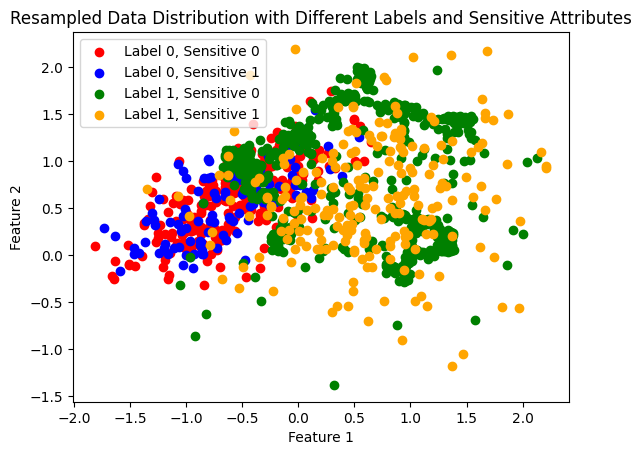

In [37]:
# Summarize the new class distribution
counter = Counter(X_OS['label'])
print("After Running SMOTE", counter)

# Plot the resampled dataset with four colors
colors = { (0, 0): 'red', (0, 1): 'blue', (1, 0): 'green', (1, 1): 'orange' }
for (label, sensitive_attr), color in colors.items():
    row_ix = np.where((X_OS['label'] == label) & (X_OS['sensitive_attribute'] == sensitive_attr))[0]
    plt.scatter(X_OS.iloc[row_ix, 0], X_OS.iloc[row_ix, 1], label=f'Label {label}, Sensitive {sensitive_attr}', c=color)

plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Resampled Data Distribution with Different Labels and Sensitive Attributes')
plt.show()

In [38]:
train_counts_OS = X_OS.groupby(['label', 'sensitive_attribute']).size().reset_index(name='count')
print(train_counts_OS)

   label  sensitive_attribute  count
0    0.0                  0.0    233
1    0.0                  1.0    117
2    1.0                  0.0    593
3    1.0                  1.0    227


In [39]:
# Train a logisitic regression model
# Train the model with the training subset
# Train a logistic regression model
logreg = LogisticRegression()
logreg.fit(X_OS[['feature1', 'feature2']], X_OS['label'])

# Test the model on the test subset
result_OS = logreg.predict(X_test)
# Display the confusion matrix to check the performance of your model
confusion_matrix(result_OS, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[105,   8],
       [ 45, 142]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


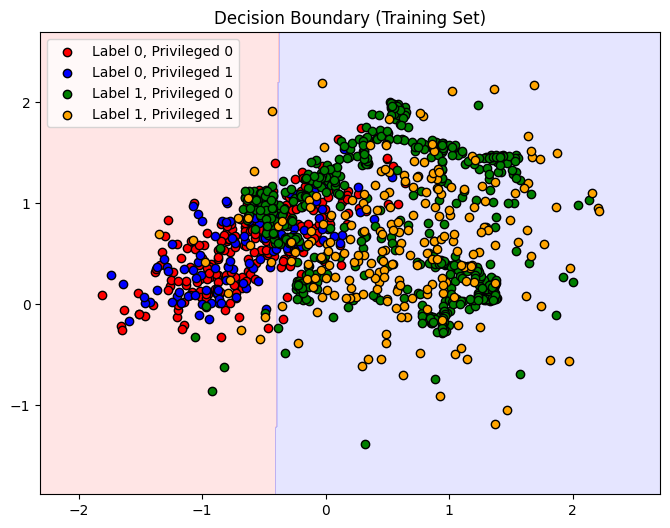

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


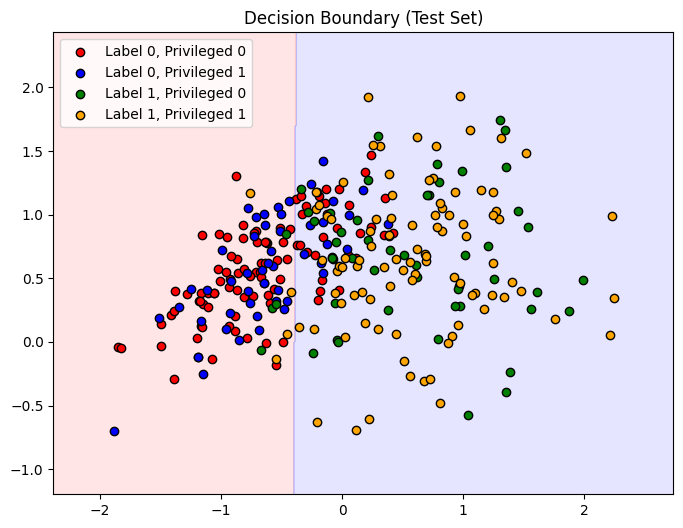

In [40]:
# Plot decision boundary for the training set
plot_decision_boundary(X_OS[['feature1', 'feature2']].values, X_OS['label'].values, X_OS['sensitive_attribute'].values, logreg, 'Decision Boundary (Training Set)', figsize=(8,6))

# Plot decision boundary for the test set
plot_decision_boundary(X_test, y_test, sensitive_attr_test, logreg, 'Decision Boundary (Test Set)',figsize=(8,6))

In [41]:
f1 = f1_score(y_test, result_OS, average=None)
acc = accuracy_score(y_test, result_OS, normalize=True)
bacc = balanced_accuracy_score(y_test, result_OS)
print ("F1-Score = {}\nAccuracy = {}\nBalanced Accuracy = {}".format(f1, acc, bacc))

F1-Score = [0.79847909 0.84272997]
Accuracy = 0.8233333333333334
Balanced Accuracy = 0.8233333333333333


In [42]:
sensitive_groups = [0, 1]
for sensitive_group in sensitive_groups:
    y_test_group = y_test[sensitive_attr_test == sensitive_group]
    y_pred_group = result_OS[sensitive_attr_test == sensitive_group]

    cm_group = confusion_matrix(y_pred_group, y_test_group)
    print(f"Confusion Matrix for Sensitive Attribute = {sensitive_group}:")
    print(cm_group)


Confusion Matrix for Sensitive Attribute = 0:
[[69  4]
 [31 49]]
Confusion Matrix for Sensitive Attribute = 1:
[[36  4]
 [14 93]]


In [43]:
!pip install aif360

In [44]:

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

# Define privileged and unprivileged groups
privileged_groups = [{'sensitive_attribute': 1}]
unprivileged_groups = [{'sensitive_attribute': 0}]

# Create a BinaryLabelDataset for the test set and predictions
X_test_df = pd.DataFrame(X_test, columns=['feature1', 'feature2'])
X_test_with_predictions = X_test_df.copy()
X_test_normal = X_test_df.copy()
X_test_with_predictions['sensitive_attribute'] = sensitive_attr_test
X_test_normal['sensitive_attribute'] = sensitive_attr_test
X_test_normal['label'] = y_test
X_test_with_predictions['label'] = result_OS.astype(int)



# Convert the dataset to BinaryLabelDataset format
dataset_test_OS = BinaryLabelDataset(df=X_test_normal, label_names=['label'], protected_attribute_names=['sensitive_attribute'])
dataset_test_pred_OS = BinaryLabelDataset(df=X_test_with_predictions, label_names=['label'], protected_attribute_names=['sensitive_attribute'])

# Compute the ClassificationMetric
metric_OS = ClassificationMetric(dataset_test_OS, dataset_test_pred_OS, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("WITH OVERSAMPLING")
# Compute Disparate Impact
disparate_impact_OS = metric_OS.disparate_impact()
print(f'Disparate Impact OS: {disparate_impact_OS}')

# Compute Equal Opportunity Difference
equal_opportunity_difference_OS = metric_OS.equal_opportunity_difference()
print(f'Equal Opportunity Difference: {equal_opportunity_difference_OS}')


WITH OVERSAMPLING
Disparate Impact OS: 0.7183434121312077
Equal Opportunity Difference: -0.03423458471114571


In [45]:


# Create a BinaryLabelDataset for the test set and predictions
X_test_df = pd.DataFrame(X_test, columns=['feature1', 'feature2'])
X_test_with_predictions = X_test_df.copy()
X_test_normal = X_test_df.copy()
X_test_with_predictions['sensitive_attribute'] = sensitive_attr_test
X_test_normal['sensitive_attribute'] = sensitive_attr_test
X_test_normal['label'] = y_test
X_test_with_predictions['label'] = result.astype(int)



# Convert the dataset to BinaryLabelDataset format
dataset_test_OS = BinaryLabelDataset(df=X_test_normal, label_names=['label'], protected_attribute_names=['sensitive_attribute'])
dataset_test_pred_OS = BinaryLabelDataset(df=X_test_with_predictions, label_names=['label'], protected_attribute_names=['sensitive_attribute'])

# Compute the ClassificationMetric
metric = ClassificationMetric(dataset_test_OS, dataset_test_pred_OS, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("NO OVERSAMPLING")
# Compute Disparate Impact
disparate_impact = metric.disparate_impact()
print(f'Disparate Impact OS: {disparate_impact}')

# Compute Equal Opportunity Difference
equal_opportunity_difference = metric.equal_opportunity_difference()
print(f'Equal Opportunity Difference: {equal_opportunity_difference}')


NO OVERSAMPLING
Disparate Impact OS: 0.5474236206110351
Equal Opportunity Difference: -0.10095312196070794
